In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install nltk
!pip install sastrawi
!pip install clean_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 10.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=a2e555f13e34aeffbd9c6e4c4275606ce6e90c067de7bf6aa3c1558ef8d87844
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


#**Library**

In [3]:
import pandas as pd
import re
from cleantext import clean
import nltk
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split

import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from keras.models import load_model

import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Introducing global variable**

In [4]:
factory_stopwords = StopWordRemoverFactory()
stopword = factory_stopwords.create_stop_word_remover()
factory_stems = StemmerFactory()
stemmers = factory_stems.create_stemmer()
set_stopwords_nltk = set(stopwords.words('indonesian'))
stopwords_nltk = list(set_stopwords_nltk)
custom_word = ['nya', 'sih', 'dan', 'yang', 'ada', 'di', 'ini', 'dari', 'jadi', 'ke', 'itu', 'sana', 'sini', 'ya', 'nih', 'iya']
all_stopwords = stopwords_nltk + custom_word
dictionary = ArrayDictionary(all_stopwords)
stopwordremover = StopWordRemover(dictionary)
alay  = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MachineLearning-Sentiment/01Sentiment_Analysis/allkamusalay.csv')
dict_alay = dict(alay.values)

In [ ]:
file = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MachineLearning-Sentiment/01Sentiment_Analysis/Balanced_Tweet.csv')

# **Preprocessing**

In [ ]:
def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
  text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
  text = re.sub(r'RT[\s]', '', text) # remove RT
  text = re.sub(r"http\S+", '', text) # remove link
  text = re.sub(r'[0-9]+', '', text) # remove numbers
  text = text.replace('\n', ' ') # replace new line into space
  text = ' '.join(dict.fromkeys(text.split())) #Remove repetitive
  text = ' '.join(dict_alay.get(alay_word,alay_word) for alay_word in text.split())
  text = text.translate(str.maketrans('','', string.punctuation))
  return text

def casefoldingText(text):
  text = text.lower() 
  return text

def tokenizingText(text):
  text = word_tokenize(text) 
  return text

def removestopWord(text):
  text = ' '.join([i for i in text if i not in all_stopwords])
  return text

def stemmingText(text):
  text = stemmers.stem(text)
  return text

In [ ]:
file['Tweet_Clean'] = file.Tweet.apply(cleaningText)
file['Tweet_Clean'] = file.Tweet_Clean.apply(casefoldingText)
file['Tweet_Clean_Preprocessed'] = file.Tweet_Clean.apply(tokenizingText)
file['Tweet_Clean_Preprocessed'] = file.Tweet_Clean_Preprocessed.apply(removestopWord)
file['Tweet_Clean_Preprocessed'] = file.Tweet_Clean_Preprocessed.apply(stemmingText)
file.drop_duplicates(subset = 'Tweet_Clean', inplace = True)
file.dropna(subset = ['Sentiment'], inplace = True)
file.to_csv('Dataset.csv', index=False)

In [5]:
file = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MachineLearning-Sentiment/01Sentiment_Analysis/Dataset_final.csv')
file = file.dropna()
positive_label = file.loc[file['Sentiment'] == 'positive'].Sentiment.tolist()
negative_label = file.loc[file['Sentiment'] == 'negative'].Sentiment.tolist()
neutral_label  = file.loc[file['Sentiment'] == 'neutral'].Sentiment.tolist()
total_label = positive_label + negative_label + neutral_label

positive = file.loc[file['Sentiment'] == 'positive'].Tweet_Clean_Preprocessed.tolist()
negative = file.loc[file['Sentiment'] == 'negative'].Tweet_Clean_Preprocessed.tolist()
neutral  = file.loc[file['Sentiment'] == 'neutral'].Tweet_Clean_Preprocessed.tolist()

total_data = positive + negative + neutral
print(total_data)
print(len(negative_label), len(positive_label), len(neutral_label))

['warung milik usaha pabrik puluh kenal putih bandung kualitas padu ahli masak kretivitas saji menu utama bahan tambah ayam selera indonesia harga jangkau lewat bletoka kalah asli tegal', 'lokasi strategis jalan sumatra bandung nyaman sofa lantai paella enak pas makan minum bir dingin appetiser enakenak', 'betapa bahagia unboxing paket barang bagus tetap beli', 'makan agam harga food stall kasir suasana ramai perhati parkir duduk', 'unik bagus foto makan enak pegawai ramah bersih luas wifi kencang harga standar sesuai menu masakan barat indonesia favorit lychee mojito spagheti', 'keluarga nikmat alam kuliner senang rm sari sunda jalan setiabudhi bandung hubung tulis maaf rekanrekan baca bingung suka restoran layan bilang cepat', 'syukur', 'cerita alam pesan steak grilled beef saji potong buruk kualitas daging enggan mes menu khusus sirloin lemak ukur menumenu tempel lidah saran beli label cheese lanjut', 'habis puas main trans studio bandung teman sepakat makan ayam kakek enak gurih', 

# **Explanatory Data Analysis (EDA)**



  Sentiment  Number
0  Positive    6378
1  Negative    6042
2   Neutral    6097


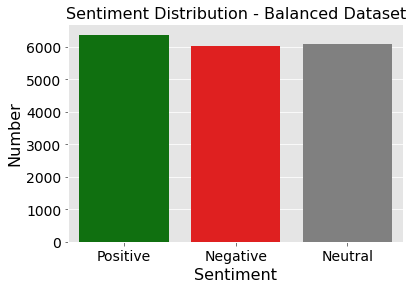

In [ ]:
#Data Distribution
import seaborn as sns
data_distribution = {'Sentiment' : ['Positive', 'Negative', 'Neutral'], 
                     'Number' : [len(positive_label), len(negative_label), len(neutral_label)]}
data_dist = pd.DataFrame(data_distribution)
print(data_dist)
color = ['Green', 'Red', 'Gray']
sns.barplot(data=data_dist, x="Sentiment", y="Number", palette=color)
plt.xlabel('Sentiment', fontsize=16, color='black')
plt.ylabel('Number', fontsize=16, color='black')
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.title("Sentiment Distribution - Balanced Dataset", fontsize=16)
plt.show()

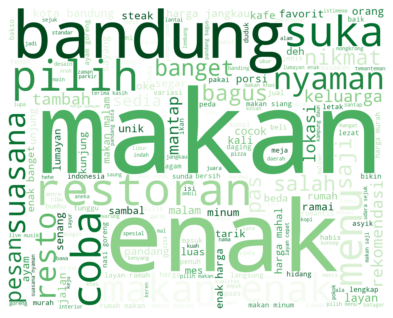

In [ ]:
from wordcloud import WordCloud
positive_sentiment = file[file['Sentiment'] == 'positive']

all_text = ' '.join(word for word in positive_sentiment['Tweet_Clean_Preprocessed'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=800, mode='RGBA', background_color='white').generate(all_text)

plt.figure(figsize=(10,5), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

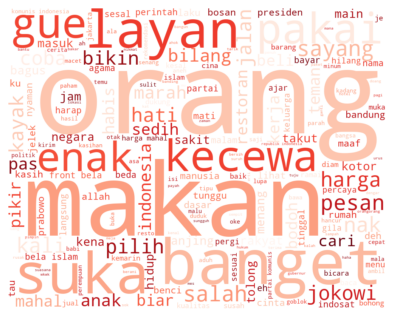

In [ ]:
negative_sentiment = file[file['Sentiment'] == 'negative']

all_text = ' '.join(word for word in negative_sentiment['Tweet_Clean_Preprocessed'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=800, mode='RGBA', background_color='white').generate(all_text)

plt.figure(figsize=(10,5), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

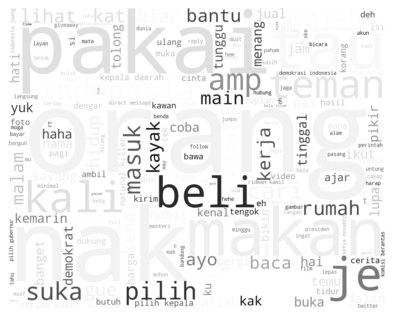

In [ ]:
neutral_sentiment = file[file['Sentiment'] == 'neutral']

all_text = ' '.join(word for word in neutral_sentiment['Tweet_Clean_Preprocessed'])
wordcloud = WordCloud(colormap='Greys', width=1000, height=800, mode='RGBA', background_color='white').generate(all_text)

plt.figure(figsize=(10,5), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# **Tokenazing and sequencing text**

In [7]:
max_feature = 5000
tokenizer = Tokenizer(num_words = max_feature, split = ' ', lower=True)
tokenizer.fit_on_texts(total_data)

with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('Tokenizer.pickle has been created')

X = tokenizer.texts_to_sequences(total_data)
vocab_size = len(tokenizer.word_index)
max_len = max(len(x) for x in X)
print(max_len)
X = pad_sequences(X)

with open('x_pad_sequences.pickle', 'wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has been created')

with open('x_pad_sequences.pickle', 'rb') as x_pad_sequences:
  pickle.load(x_pad_sequences)

Y = pd.get_dummies(total_label)
Y = Y.values
print(Y)
with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has been created')

with open('y_labels.pickle', 'rb') as y_labels:
  pickle.load(y_labels)

print(X.shape, Y.shape)

Tokenizer.pickle has been created
43
x_pad_sequences.pickle has been created
[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]
y_labels.pickle has been created
(18517, 43) (18517, 3)


# **Devide data to test and training**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14813, 43) (14813, 3)
(3704, 43) (3704, 3)


# **Introducing Model**

In [ ]:
import tensorflow as tf

optim_dict = {"adam":tf.keras.optimizers.Adam, "RMSprop":tf.keras.optimizers.RMSprop, "SGD":tf.keras.optimizers.SGD }
def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = "adam", learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_feature, output_dim = embed_dim, input_length = X_train.shape[1]))
    model.add(LSTM(units = hidden_unit, dropout = dropout_rate))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))   
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optim_dict[optimizers](learning_rate = learning_rate), metrics = ['accuracy'])
    return model

# **Hyperparameter Tuning**

In [ ]:
# Hyperparameter tuning
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dropout
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
f1 = make_scorer(f1_score, average='weighted')

# Wrapper model with default hyperparameter values
model =  KerasClassifier(build_fn = create_model, epochs = 25, batch_size=128) 

# Hyperparameters
embed_dim = [64]
hidden_unit = [32]
dropout_rate = [0.2]
optimizers = ["SGD"]
learning_rate = [0.001]
epochs = [50]
batch_size = [32]
param_grid = dict(embed_dim = embed_dim, hidden_unit = hidden_unit, dropout_rate = dropout_rate,
                  learning_rate = learning_rate, optimizers = optimizers, epochs = epochs, batch_size = batch_size)


# Evaluation model with GridSearchCV to know what the best hyperparameter for model 
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)

grid_result = grid.fit(X_train, y_train)

results = pd.DataFrame()
results['means'] = grid_result.cv_results_['mean_test_score']
results['stds'] = grid_result.cv_results_['std_test_score']
results['params'] = grid_result.cv_results_['params']
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
results.to_csv(r'params_opt.csv', index = False, header = True)
results.sort_values(by='means', ascending = False).reset_index(drop=True)

<ipython-input-9-76315c76a22d>:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model =  KerasClassifier(build_fn = create_model, epochs = 25, batch_size=128)


Epoch 1/50
309/309 [==============================] - 13s 32ms/step - loss: 1.0980 - accuracy: 0.3384
Epoch 2/50
309/309 [==============================] - 8s 27ms/step - loss: 1.0966 - accuracy: 0.4153
Epoch 3/50
309/309 [==============================] - 10s 32ms/step - loss: 1.0951 - accuracy: 0.4621
Epoch 4/50
309/309 [==============================] - 10s 33ms/step - loss: 1.0934 - accuracy: 0.4808
Epoch 5/50
309/309 [==============================] - 8s 27ms/step - loss: 1.0914 - accuracy: 0.4908
Epoch 6/50
309/309 [==============================] - 10s 33ms/step - loss: 1.0895 - accuracy: 0.4958
Epoch 7/50
309/309 [==============================] - 13s 41ms/step - loss: 1.0872 - accuracy: 0.4974
Epoch 8/50
309/309 [==============================] - 9s 30ms/step - loss: 1.0847 - accuracy: 0.5123
Epoch 9/50
309/309 [==============================] - 9s 31ms/step - loss: 1.0819 - accuracy: 0.5219
Epoch 10/50
309/309 [==============================] - 10s 33ms/step - loss: 1.0792 - 

,means,stds,params
0,0.57733,0.00354,"{'batch_size': 32, 'dropout_rate': 0.2, 'embed..."


In [ ]:
import pandas as pd
results = pd.read_csv('params_opt.csv')
results = results.sort_values(by='means', ascending = False)
results.to_csv("Opt-3.csv", index='False')

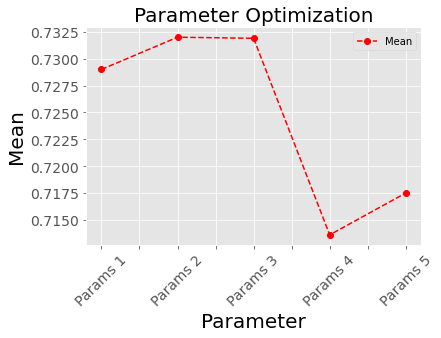

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
data_opt = {"Mean" : [0.729,0.732, 0.7319, 0.7136,0.7175 ],
            "Parameter" : ['Params 1', 'Params 2', 'Params 3', 'Params 4', 'Params 5']}
parameter = pd.DataFrame(data_opt)
plot = parameter.plot(x="Parameter", y='Mean',marker='o', color='r', linestyle='--')
plt.xticks(rotation=45, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.xlabel("Parameter", fontsize=20, color='black')
plt.ylabel("Mean", fontsize=20, color='black')
plt.title("Parameter Optimization", fontsize=20)
plt.show()

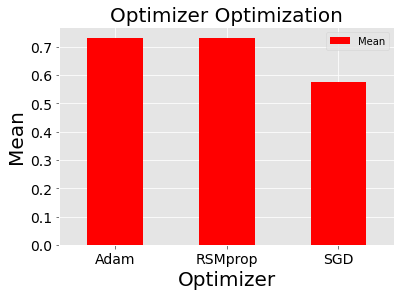

In [ ]:
import matplotlib.pyplot as plt
data_opt = {"Mean" : [0.732,0.731, 0.577],
            "Optimizer" : ['Adam', 'RSMprop', 'SGD']}
optimizer = pd.DataFrame(data_opt)
plot = optimizer.plot(x="Optimizer", y='Mean', color='red', kind='bar')
plt.xticks(rotation=0, fontsize=14, color='black')
plt.yticks(rotation=0, fontsize=14, color='black')
plt.xlabel("Optimizer", fontsize=20, color='black')
plt.ylabel("Mean", fontsize=20, color='black')
plt.title("Optimizer Optimization", fontsize=20)
plt.show()

# **Test the optimized model**

In [10]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

embed_dim = 64
units = 32
model = Sequential()
model.add(Embedding(max_feature, embed_dim, input_length = X.shape[1]))
model.add(LSTM(units, dropout=0.3))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam , metrics= ['accuracy'])
es = EarlyStopping(monitor ='val_loss', mode = 'min', verbose =1, patience=10)

filepath = '/content/best_model_LSTM.h5'
model_check = ModelCheckpoint(filepath,
    monitor ='val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq ='epoch',
    options=None,
    initial_value_threshold=None)

callbacks = [es, model_check]
history = model.fit(X_train, y_train, epochs = 5000, batch_size = 256, validation_data = (X_test, y_test), verbose=1, callbacks=callbacks)
predictions = model.predict(X_test)
y_predict = predictions
accuracy = accuracy_score(y_test.argmax(axis=1), y_predict.argmax(axis=1))
print(accuracy)
print(model.evaluate(X_test,y_test))
print(classification_report(y_test.argmax(axis=1), y_predict.argmax(axis=1)))
print(model.summary())

Epoch 1/5000
58/58 [==============================] - 9s 92ms/step - loss: 0.8941 - accuracy: 0.5605 - val_loss: 0.6918 - val_accuracy: 0.6304
Epoch 2/5000
58/58 [==============================] - 5s 81ms/step - loss: 0.6534 - accuracy: 0.6421 - val_loss: 0.6275 - val_accuracy: 0.7114
Epoch 3/5000
58/58 [==============================] - 7s 116ms/step - loss: 0.5534 - accuracy: 0.7419 - val_loss: 0.5403 - val_accuracy: 0.7657
Epoch 4/5000
58/58 [==============================] - 5s 81ms/step - loss: 0.4197 - accuracy: 0.8323 - val_loss: 0.5215 - val_accuracy: 0.7781
Epoch 5/5000
58/58 [==============================] - 6s 103ms/step - loss: 0.3530 - accuracy: 0.8661 - val_loss: 0.5567 - val_accuracy: 0.7762
Epoch 6/5000
58/58 [==============================] - 7s 114ms/step - loss: 0.3156 - accuracy: 0.8824 - val_loss: 0.5761 - val_accuracy: 0.7781
Epoch 7/5000
58/58 [==============================] - 5s 82ms/step - loss: 0.2885 - accuracy: 0.8903 - val_loss: 0.6231 - val_accuracy: 0.7

In [ ]:
print(y_test.argmax(axis=1))
print(y_predict.argmax(axis=1))

[0 0 0 ... 2 1 0]
[0 0 1 ... 2 1 0]


# **Plot training and test validation accuracy and loss**

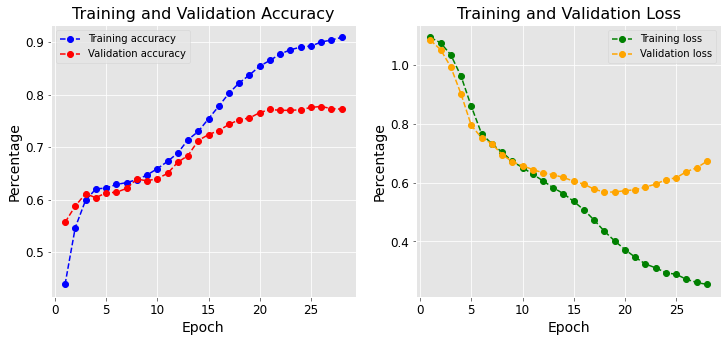

In [ ]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  #f1 = history.history['']
  #val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label ='Training accuracy', marker='o', linestyle='--')
  plt.plot(x, val_acc, 'r', label ='Validation accuracy', marker='o', linestyle='--')
  plt.xticks(fontsize=12, color='black')
  plt.yticks(fontsize=12, color='black')
  plt.xlabel("Epoch", fontsize=14, color='black')
  plt.ylabel("Percentage", fontsize=14, color='black')
  plt.title('Training and Validation Accuracy', fontsize=16)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label ='Training loss', marker='o', linestyle='--', color='green')
  plt.plot(x, val_loss, 'r', label ='Validation loss', marker='o', linestyle='--', color='orange')
  plt.xlabel("Epoch", fontsize=14, color='black')
  plt.ylabel("Percentage", fontsize=14, color='black')
  plt.xticks(fontsize=12, color='black')
  plt.yticks(fontsize=12, color='black')
  plt.title('Training and Validation Loss', fontsize=16)
  plt.legend()

%matplotlib inline
plot_history(history)

# **Plot confusion matrix**

116/116 [==============================] - 1s 12ms/step
[0 0 0 ... 2 1 0]
[0 0 1 ... 2 1 0]


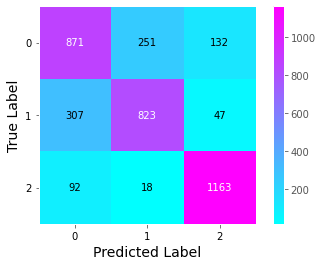

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(y_true)
print(y_pred)

cm = confusion_matrix(y_true, y_pred)
#y_test=np.argmax(y_test, axis=1)


class_dict = ['Neutral', 'Positive', 'Negative']
plot_confusion_matrix(conf_mat=cm, colorbar=True, cmap='cool')
plt.xlabel("Predicted Label", fontsize=14, color='black')
plt.ylabel("True Label", fontsize=14, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.show()

# **Test the model to unseen data**

In [ ]:
input_text = "Semua pergi segera"
sentiment = ['negative', 'neural', 'positive']
text = input_text
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen = X.shape[1])

model = load_model('best_model.h5')
model.summary()
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
print(polarity)

print("Text : ", text[0])
print("Sentiment : ", sentiment[polarity])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 43, 64)            320000    
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_24 (Dense)            (None, 100)               3300      
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 50)                5050      
                                                                 
 dense_26 (Dense)            (None, 3)                 153       
                                                                 
Total params: 340,919
Trainable params: 340,919
Non-tr

1/1 [==============================] - 1s 645ms/step
1
Text :  S
Sentiment :  negative
